# Human Protein Multi Label Image Classification

In [81]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

#from pytorchtools import EarlyStopping
from sklearn.metrics import f1_score
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

## Preparing the Data

In [82]:
DATA_DIR = '../input/jovian-pytorch-z2g/Human protein atlas'  ## Data directory in kaggle

TRAIN_DIR = DATA_DIR + '/train'                           
TEST_DIR = DATA_DIR + '/test'                             

TRAIN_CSV = DATA_DIR + '/train.csv'                       
TEST_CSV = '../input/jovian-pytorch-z2g/submission.csv' 

In [83]:
data_df = pd.read_csv(TRAIN_CSV)
data_df.head()

,Image,Label
0,19567,9
1,29993,6 4
2,17186,1 4
3,29600,6 2
4,701,3 4


In [84]:
labels = {
    0: 'Mitochondria',
    1: 'Nuclear bodies',
    2: 'Nucleoli',
    3: 'Golgi apparatus',
    4: 'Nucleoplasm',
    5: 'Nucleoli fibrillar center',
    6: 'Cytosol',
    7: 'Plasma membrane',
    8: 'Centrosome',
    9: 'Nuclear speckles'
}

In [85]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [86]:
class HumanProteinDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['Image'], row['Label']
        img_fname = self.root_dir + "/" + str(img_id) + ".png"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, encode_label(img_label)

### Data augmentations

In [7]:
## Using half of the training data to tune the hyperparameters. Once the hyperparameters are fixed at optimum value, 
## then the whole training set is used to train the model.

run = int(len(data_df)/2)
half_df = data_df[:run]
run

9618

In [87]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = T.Compose([
    T.RandomCrop(512, padding=8, padding_mode='reflect'),
#    T.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    T.RandomHorizontalFlip(), 
    T.RandomRotation(10),
    T.ToTensor(), 
#    T.Normalize(*imagenet_stats,inplace=True), 
    T.RandomErasing(inplace=True)
])

valid_tfms = T.Compose([
#    T.Resize(256), 
    T.ToTensor(), 
#    T.Normalize(*imagenet_stats)
])


## The model gave better results without normalization since it was a pretrained model.

In [88]:
np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.9

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

In [89]:
train_ds = HumanProteinDataset(train_df, TRAIN_DIR, transform=train_tfms)
val_ds = HumanProteinDataset(val_df, TRAIN_DIR, transform=valid_tfms)
len(train_ds), len(val_ds)

(17335, 1901)

In [90]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

Labels: Cytosol(6) Plasma membrane(7)


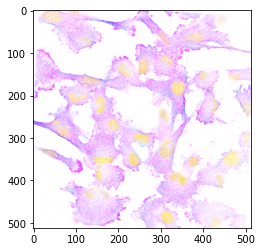

In [91]:
show_sample(*train_ds[1541])

### DataLoaders

In [92]:
batch_size = 16

In [93]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, 
                    num_workers=2, pin_memory=True)

In [94]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

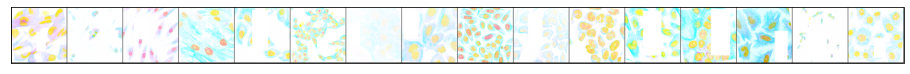

In [16]:
show_batch(train_dl, invert=True)

## Model - Using Transfer Learning

In [95]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [96]:
class MultilabelImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [98]:
resnext50_32x4d = models.resnext50_32x4d()
resnext50_32x4d

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [99]:
class ProteinResnext(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Using a pretrained model
        self.network = models.resnext50_32x4d(pretrained=True)
        # Replacing fully connected layers
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
                            nn.Linear(num_ftrs, 512),
                            nn.BatchNorm1d(512),
                            nn.ReLU(inplace = True),
                            nn.Linear(512, 10))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # To unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [100]:
p = ProteinResnext()
p

ProteinResnet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample):

In [101]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [102]:
device = get_default_device()
device

device(type='cuda')

In [103]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Training

In [104]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Setting up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Setting up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Recording & updating learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [105]:
model = to_device(ProteinResnext(), device)

In [106]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6868839859962463, 'val_score': 0.2676057517528534}]

In [107]:
model.freeze()   ## Freezing to avoid the training of the layers of pretrained resnext

In [108]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-5
opt_func = torch.optim.SGD

In [109]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


weights_fname = 'protein-resnext-1.pth'
torch.save(model.state_dict(), weights_fname)


model.unfreeze()      ## Unfreezing to train the whole network together but with very small learning rate


history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


weights_fname = 'protein-resnext-2.pth'
torch.save(model.state_dict(), weights_fname)


Epoch [0], last_lr: 0.0028, train_loss: 0.3107, val_loss: 0.2290, val_score: 0.6233



Epoch [1], last_lr: 0.0076, train_loss: 0.2212, val_loss: 0.2026, val_score: 0.7194



Epoch [2], last_lr: 0.0100, train_loss: 0.1979, val_loss: 0.1825, val_score: 0.7597



Epoch [3], last_lr: 0.0095, train_loss: 0.1840, val_loss: 0.1783, val_score: 0.7613



Epoch [4], last_lr: 0.0081, train_loss: 0.1732, val_loss: 0.1892, val_score: 0.7538



Epoch [5], last_lr: 0.0061, train_loss: 0.1627, val_loss: 0.1686, val_score: 0.7750



Epoch [6], last_lr: 0.0039, train_loss: 0.1501, val_loss: 0.1680, val_score: 0.7920



Epoch [7], last_lr: 0.0019, train_loss: 0.1361, val_loss: 0.1648, val_score: 0.7959



Epoch [8], last_lr: 0.0005, train_loss: 0.1197, val_loss: 0.1595, val_score: 0.8069



Epoch [9], last_lr: 0.0000, train_loss: 0.1077, val_loss: 0.1589, val_score: 0.8034



Epoch [0], last_lr: 0.0003, train_loss: 0.1040, val_loss: 0.1623, val_score: 0.8030



Epoch [1], last_lr: 0.0008, train_loss: 0.1037, val_loss: 0.1611, val_score: 0.8017



Epoch [2], last_lr: 0.0010, train_loss: 0.1033, val_loss: 0.1634, val_score: 0.8057



Epoch [3], last_lr: 0.0010, train_loss: 0.0992, val_loss: 0.1637, val_score: 0.7948



Epoch [4], last_lr: 0.0008, train_loss: 0.0963, val_loss: 0.1662, val_score: 0.8003



Epoch [5], last_lr: 0.0006, train_loss: 0.0916, val_loss: 0.1661, val_score: 0.8057



Epoch [6], last_lr: 0.0004, train_loss: 0.0897, val_loss: 0.1675, val_score: 0.8013



Epoch [7], last_lr: 0.0002, train_loss: 0.0863, val_loss: 0.1683, val_score: 0.8071



Epoch [8], last_lr: 0.0000, train_loss: 0.0829, val_loss: 0.1686, val_score: 0.8038



Epoch [9], last_lr: 0.0000, train_loss: 0.0816, val_loss: 0.1689, val_score: 0.8039
CPU times: user 3h 27min 6s, sys: 2h 27min 23s, total: 5h 54min 29s
Wall time: 6h 5min


In [132]:
train_time='6h 5min'

In [110]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('F1 score vs. No. of epochs');

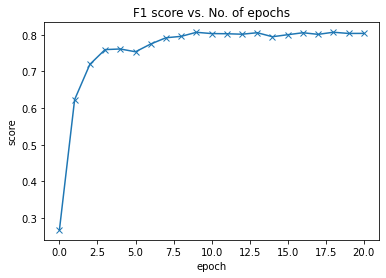

In [111]:
plot_scores(history)

In [112]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

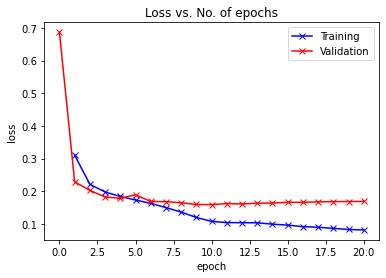

In [113]:
plot_losses(history)

In [114]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

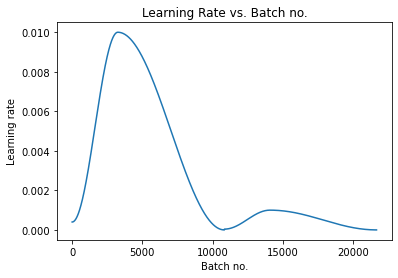

In [115]:
plot_lrs(history)

## Making Predictions

In [116]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

In [117]:
test_df = pd.read_csv(TEST_CSV)
test_dataset = HumanProteinDataset(test_df, TEST_DIR, transform=valid_tfms)

In [118]:
img, target = test_dataset[0]
img.shape

torch.Size([3, 512, 512])

Prediction:  tensor([5.8378e-05, 1.5696e-03, 9.5450e-06, 5.1522e-06, 9.9986e-01, 2.7776e-06,
        9.8365e-01, 2.2066e-04, 4.4836e-05, 3.5640e-06], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Nucleoplasm(4) Cytosol(6)


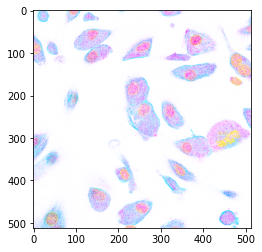

In [119]:
predict_single(test_dataset[100][0])

Prediction:  tensor([8.7774e-01, 1.2570e-04, 2.6270e-03, 2.0012e-02, 6.2890e-02, 4.4386e-03,
        8.1122e-03, 2.0500e-03, 8.4483e-03, 1.5273e-03], device='cuda:0',
       grad_fn=<SelectBackward>)
Labels: Mitochondria(0)


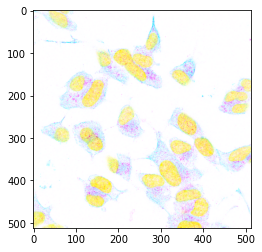

In [120]:
predict_single(test_dataset[74][0])

In [121]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size, num_workers=3, pin_memory=True), device)

In [122]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [123]:
test_preds = predict_dl(test_dl, model)

In [124]:
submission_df = pd.read_csv(TEST_CSV)
submission_df.Label = test_preds
submission_df.sample(20)

,Image,Label
5168,27233,6
6336,26023,4
5962,2884,6
6513,27639,9
5100,12658,8
5971,24299,2 6
4931,23286,4 6
1,15322,4
5122,6801,4
6285,7597,3 4


In [125]:
sub_fname = 'submission.csv'

In [126]:
submission_df.to_csv(sub_fname, index=False)

## Saving

In [127]:
weights_fname = 'protein-resnext-final.pth'
torch.save(model.state_dict(), weights_fname)